In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                             
import tensorflow as tf                
from tqdm import tqdm
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("images-classification-using-cnn&pyspark").setMaster("spark://kyoraku:7077")
sc = SparkContext(conf=conf)


In [2]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from pyspark import SparkContext, SparkConf
from elephas.utils.rdd_utils import to_simple_rdd
from elephas.spark_model import SparkModel

In [3]:
#class_names = ['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers', 'foods','horses','monuments','mountains_and_snow','peolpe_and_villages_in_Africa']
class_names = ['beaches', 'bus', 'dinosaurs', 'elephants', 'flowers', 'foods','horses']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
print(nb_classes)

7


In [4]:
def load_data(dataset):
       
    #Initialiser la variable impages et lables
    images = [] #cette liste va contenir les images 
    labels = [] #cette liste va contenir les labels des images 
    
    print("Loading {}".format(dataset))    
    # Itérer à travers chaque sous-dossier du (train/test dossier) 
        #Chaque sous-dossier correspond à une catégorie 
    for folder in os.listdir(dataset):
        label = class_names_label[folder]    
            # Parcourir toutes les images dans une catégorie 
        
        for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
            # Sauvegarder le chemin vers l'image
            img_path = os.path.join(os.path.join(dataset, folder), file)
                # Ouvrir l'iamges 
            image = cv2.imread(img_path)
                # Ramener les 3 composantes de couleurs RGB pour chaque pixel
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                # redimensionner l'image (150*150)
            image = cv2.resize(image, (150, 150)) 
                #  Ajoutez l'image à la liste
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            images.append(image)
            # Ajouter son étiquette correspondante à la liste
            labels.append(label)
        
    #On va rajouter les éléments de ces deux listes images/labels à output
    output=(images, labels)
        #on va lire les élements de la liste output en parallele
        #out=sc.parallelize(output)
    return output
#entrer le chemin de fichier d'apprentissage 
(train_images, train_labels) = load_data('training_set')
#entrer le chemin de fichier de teste
(test_images, test_labels) = load_data('test_set')


 28%|██▊       | 25/90 [00:00<00:00, 249.27it/s]

Loading training_set


100%|██████████| 10/10 [00:00<00:00, 381.02it/s]

Loading test_set


In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels=np.array(test_labels)
print(type(test_images),type(train_labels))
print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
630
630
70
70


In [6]:
def nb_to_dict(trainlabels,trainimages):
    mdict = {}
    for A, B in zip(trainlabels, trainimages):
        mdict[A] = B
    #rdd = sc.parallelize(mdict.items(),10)
    #rdd.collect()
    dict = {}
    for i in range(6):
        dict[i]=mdict
    return (mdict,dict)
(mdict,dict)=nb_to_dict(train_labels,train_images)
print(dict)

{0: {1: array([[[0.43137255, 0.5921569 , 0.8117647 ],
        [0.43137255, 0.5882353 , 0.8117647 ],
        [0.44705883, 0.60784316, 0.827451  ],
        ...,
        [0.53333336, 0.41568628, 0.2627451 ],
        [0.59607846, 0.43137255, 0.2627451 ],
        [0.38431373, 0.25882354, 0.12941177]],

       [[0.4392157 , 0.6       , 0.81960785],
        [0.4392157 , 0.6       , 0.81960785],
        [0.44705883, 0.60784316, 0.827451  ],
        ...,
        [0.5254902 , 0.40392157, 0.25490198],
        [0.5882353 , 0.42352942, 0.25882354],
        [0.39607844, 0.27058825, 0.14117648]],

       [[0.4509804 , 0.6117647 , 0.83137256],
        [0.44705883, 0.60784316, 0.827451  ],
        [0.44705883, 0.60784316, 0.827451  ],
        ...,
        [0.5529412 , 0.42745098, 0.27058825],
        [0.6156863 , 0.44705883, 0.2784314 ],
        [0.42352942, 0.2901961 , 0.15686275]],

       ...,

       [[0.3254902 , 0.31764707, 0.37254903],
        [0.32156864, 0.3137255 , 0.36862746],
        [0.317

In [7]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(np.shape(images)[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
    print(index,np.shape(images)[0])

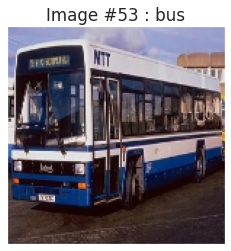

53 630


In [8]:
display_random_image(class_names, train_images, train_labels)

In [9]:
# CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Converter le dictionnaire à un RDD
rdd=sc.parallelize(mdict.items(),7)

In [12]:
import time
tps1 = time.process_time()

# Initialisation de SparkModel à partire du model
spark_model = SparkModel(model, frequency='epoch', mode='asynchronous')
#Apprentissage du nouveau modele sur les données parallelisée
spark_model.fit(rdd, epochs=2, batch_size=128,verbose=2, validation_split=0.02)

tps2 = time.process_time()
print("Temps d'execution de l'apprentissage : "+str(tps2 - tps1)+"  secondes")

>>> Fit model
 * Serving Flask app 'elephas.parameter.server' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.1.1:4000/ (Press CTRL+C to quit)


>>> Initialize workers
>>> Distribute load


127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [27/May/2021 22:53:50] "

>>> Async training complete.
Temps d'execution de l'apprentissage : 0.3963280779999998  secondes


In [21]:
#evaluation du modèle
test_loss = spark_model.evaluate(test_images,test_labels)

#Test et predition des etiquettes avec spark_model 
predictions = spark_model.predict(test_images) # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

print("loss value:"+str(test_loss[0])+"   accuracy value: "+str(test_loss[1]))

loss value:2.252519573484148   accuracy value: 0.20000000510896956


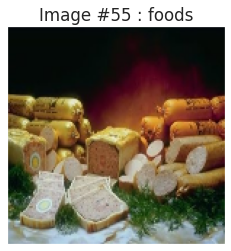

55 70


In [22]:
display_random_image(class_names, test_images, pred_labels)

In [30]:
def display_examples(class_names, images, labels):
    """
        Display 25 images du liste  images avec leur étiquettes
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(len(labels)):
        plt.subplot(5,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [31]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

In [32]:
def print_labeled_images(class_names, test_images, test_labels, pred_labels):
    
    
    BOO = (test_labels == pred_labels)
    labeled_indices = np.where(BOO == 1)
    labeled_images = test_images[labeled_indices]
    labeled_labels = pred_labels[labeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  labeled_images, labeled_labels)

In [33]:
def print_images(class_names, test_images, test_labels, pred_labels):
    """
       Visualiser  25 examples qui ont été mal-classées, e.g when test_labels != pred_labels
    """
    title = "Some examples of mislabeled images by the classifier:"
 #   print(len(labeled_images),len(labeled_labels))
    display_examples(class_names,  test_images, pred_labels)

70


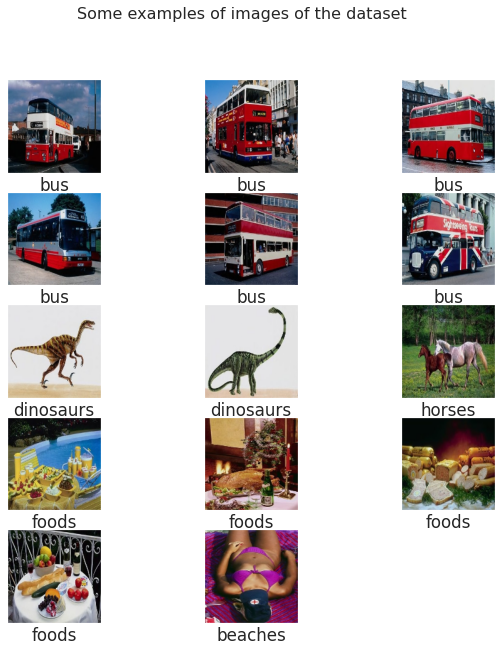

In [34]:
print_labeled_images(class_names, test_images, test_labels, pred_labels)

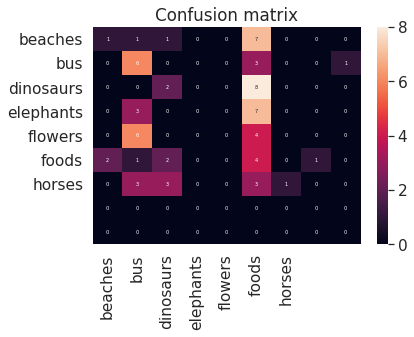

In [35]:
#La matrice de confision:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 5}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()